# Computer Exercise 1: Linear Regression

**Brief introduction**


In this exercise, we investigate five approaches to linear regression: least squares (LS), Bayesian regression, empirical Bayes regression, expectation maximization (EM), and variational Bayes (VB). The theory behind those methods is presented in Sections 3.3, 12.2.3, 12.3, 12.5, and 13.3 respectively in the [book](https://etv.itdepartment.nl/boekenlijst/etv/2020/bl106072/master-electrical-engineering?electives=&electives=tOeDCg_NdkqogRClzzobMw) by Sergios Theodoridis. Detailed derivations of empirical Bayes regression are provided in Sections 3.5.1. to 3.5.3 in the [book](https://drive.google.com/file/d/1tG3dFcgM7R9TeP-mruCWSGSg0d_892Zo/view?usp=sharing) *Pattern Recognition and Machine Learning* by Chris Bishop. 

In all five approaches, the observation model is defined as:  $$y=\pmb{\theta}^T \pmb{x} + \eta,$$


where $\pmb{x}$ and $y$ are the input and output respectively, $\eta$ are the residuals between predictions $\hat y = \pmb{\theta}^T \pmb{x}$ and the output $y$, and $\pmb{\theta}$ is a vector of unknown coefficients.

In the LS approach (the first approach we consider in this exercise), the coefficients $\pmb{\theta}$ are determined by minimizing the square loss $J(\pmb{\theta})$ between the predictions $\hat y = \pmb{\theta}^T \pmb{x}$ and ground truth $y$ (from the training data).

In the Bayesian approaches (Bayesian regression, empirical Bayes regression, EM, and VB), the residuals $\eta$ are viewed as Gaussian random variables with zero mean and variance $\beta^{-1}$, therefore, the conditional distribution $p(y | \pmb{x})$ of $y$ given $\pmb{x}$ is Gaussian:$$y\sim p(y | \pmb{x}) = \mathcal N(y|\pmb{\theta}^T \pmb{x},\beta^{-1}I).$$
Moreover, the coefficients $\pmb{\theta}$ are viewed as random variables with (prior) distribution: $$\pmb{\theta}\sim\mathcal N(\pmb{\theta}|m_0,S_0),$$ which is usually simplified as $\pmb{\theta}\sim \mathcal N(\pmb{\theta}|m_0,\alpha^{-1}I)$.

By combining both, we obtain the posterior distribution $p(\pmb{\theta}|\pmb{x},y)$ given the inputs $\pmb x$ and outputs $y$: $$\pmb{\theta}\sim p(\pmb{\theta}|\pmb{x},y) = \mathcal N(\pmb{\theta}|m_N,S_N),$$ with $$m_N=S_N(S_0^{-1}m_0+\beta X^T y),$$ $$S_N^{-1}=S_0^{-1}+\beta X^TX.$$

Computation of this posterior distribution is referred to as Bayesian regression, the second approach we consider in this exercise. In this approach, the parameters $\alpha$ and $\beta$ are unknown and need to be tuned by crossvalidation or other methods. To aid the understanding of Bayesian regression, the algorithm is implemented as class BayesianRegression() with methods fit() and predict(). 

In the empirical Bayes approach (the third approach in this exercise), the parameters $\alpha$ and $\beta$ are obtained by maximizing the evidence function. The empirical Bayes algorithm infers $\alpha$ and $\beta$ from data, therefore, no tuning is required in this approach. The theory behind this approach is presented in Section 12.3 of the book and will be discussed in Week 3 of the course, however, we will not discuss the approach in detail for linear regression. We refer to Sections 3.5.1. to 3.5.3 in the [book](https://drive.google.com/file/d/1tG3dFcgM7R9TeP-mruCWSGSg0d_892Zo/view?usp=sharing) *Pattern Recognition and Machine Learning* by Chris Bishop for detailed derivations. 

The empirical Bayes algorithm is equivalent to Bayesian ridge regression, which is implemented as class BayesianRidge() in scikit-learn. At the very end of this notebook, we compare our own implementation of LS and empiral Bayes regression to the scikit-learn implementations. As you will see, it takes only few lines of code to train and test those scikit-learn models. We strongly recommend you to experiment with ML models in [scikit-learn](https://scikit-learn.org/) and similar Python packages for your project (Assignment 3), instead of trying to code all models by yourself.

In the EM approach (the fourth approach in this exercise), the parameters $\alpha$ and $\beta$ are obtained by maximizing the $Q$-function, which is the expectation (w.r.t. the posterior in the coefficients $\pmb{\theta}$) of the log probability of the complete data ($y$, $\pmb{\theta}$). The theory behind this approach is presented in Section 12.5 of the book and will be discussed in Week 3 of the course.

In the VB approach (the fifth approach in this exercise), the parameters $\alpha$ and $\beta$ are viewed as random variables with their own prior distributions. The VB method allows us to compute the posterior distributions of $\alpha$ and $\beta$, in contrast to the other four approaches. The theory behind this approach is presented in Section 13.3 of the book and will be discussed in Week 5 of the course.

**Suggestions for Exercise 1**
- Study and run the code
 
- Questions are written inside the Notebook. Try to answer all questions.
 - Questions 1 and 2 concern LS and Bayesian regression; try those questions first.
 - Questions 3, 4, and 6 are mainly centered around the empirical Bayes and EM approach. If you prefer, you can work on those questions from Week 3 onward, once we have covered the theory in the lectures. But it is also possible to attempt those questions earlier, since you do not need to fully understand the theory in order to solve those questions.
  - Question 5 is about the VB approach. If you prefer, you can work on that question from Week 5 onward, once we have covered the theory in the lectures.  
- We will provide model answers to the questions in coming weeks. This will give you extra time to work on them, before answers are released.


<font color='green'> Note: in the code below, the coefficients $\pmb{\theta}$ are called $w$. The observations are called $t$ (instead of $y$) and predictions $y$ (instead of $\hat y$) . </font>

# Import modules and models

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(1)

The implementations below are from https://github.com/ctgk/PRML
 
Polynomial Feature

In [2]:
import itertools
import functools
import numpy as np

class PolynomialFeature(object):
    """
    polynomial features

    transforms input array with polynomial features

    Example
    =======
    x =
    [[a, b],
    [c, d]]

    y = PolynomialFeatures(degree=2).transform(x)
    y =
    [[1, a, b, a^2, a * b, b^2],
    [1, c, d, c^2, c * d, d^2]]
    """

    def __init__(self, degree=1):
        """
        construct polynomial features

        Parameters
        ----------
        degree : int
            degree of polynomial
        """
        assert isinstance(degree, int)
        self.degree = degree

    def transform(self, x):
        """
        transforms input array with polynomial features

        Parameters
        ----------
        x : (sample_size, n) ndarray
            input array

        Returns
        -------
        output : (sample_size, 1 + nC1 + ... + nCd) ndarray
            polynomial features
        """
        if x.ndim == 1:
            x = x[:, None]
        x_t = x.transpose()
        features = [np.ones(len(x))]
        for degree in range(1, self.degree + 1):
            for items in itertools.combinations_with_replacement(x_t, degree):
                features.append(functools.reduce(lambda x, y: x * y, items))
        return np.asarray(features).transpose()

Models for standard linear regression, Bayesian regression, and empirical Bayesian regression

In [3]:
import numpy as np

class LinearRegression():
    """
    Linear regression model
    y = X @ w
    t ~ N(t|X @ w, var)
    """

    def fit(self, X:np.ndarray, t:np.ndarray):
        """
        perform least squares fitting

        Parameters
        ----------
        X : (N, D) np.ndarray
            training independent variable
        t : (N,) np.ndarray
            training dependent variable
        """
        self.w = np.linalg.pinv(X) @ t
        self.var = np.mean(np.square(X @ self.w - t))

    def predict(self, X:np.ndarray, return_std:bool=False):
        """
        make prediction given input

        Parameters
        ----------
        X : (N, D) np.ndarray
            samples to predict their output
        return_std : bool, optional
            returns standard deviation of each prediction if True

        Returns
        -------
        y : (N,) np.ndarray
            prediction of each sample
        y_std : (N,) np.ndarray
            standard deviation of each prediction
        """
        y = X @ self.w
        if return_std:
            y_std = np.sqrt(self.var) + np.zeros_like(y)
            return y, y_std
        return y

In [4]:
class BayesianRegression():
    """
    Bayesian regression model

    w ~ N(w|0, alpha^(-1)I)
    y = X @ w
    t ~ N(t|X @ w, beta^(-1))
    """

    def __init__(self, alpha:float=1., beta:float=1.):
        self.alpha = alpha
        self.beta = beta
        self.w_mean = None
        self.w_precision = None

    def _is_prior_defined(self) -> bool:
        return self.w_mean is not None and self.w_precision is not None

    def _get_prior(self, ndim:int) -> tuple:
        if self._is_prior_defined():
            return self.w_mean, self.w_precision
        else:
            return np.zeros(ndim), self.alpha * np.eye(ndim)

    def fit(self, X:np.ndarray, t:np.ndarray):
        """
        bayesian update of parameters given training dataset

        Parameters
        ----------
        X : (N, n_features) np.ndarray
            training data independent variable
        t : (N,) np.ndarray
            training data dependent variable
        """

        mean_prev, precision_prev = self._get_prior(np.size(X, 1))

        w_precision = precision_prev + self.beta * X.T @ X
        w_mean = np.linalg.solve(
            w_precision,
            precision_prev @ mean_prev + self.beta * X.T @ t
        )
        self.w_mean = w_mean
        self.w_precision = w_precision
        self.w_cov = np.linalg.inv(self.w_precision)

    def predict(self, X:np.ndarray, return_std:bool=False, sample_size:int=None):
        """
        return mean (and standard deviation) of predictive distribution

        Parameters
        ----------
        X : (N, n_features) np.ndarray
            independent variable
        return_std : bool, optional
            flag to return standard deviation (the default is False)
        sample_size : int, optional
            number of samples to draw from the predictive distribution
            (the default is None, no sampling from the distribution)

        Returns
        -------
        y : (N,) np.ndarray
            mean of the predictive distribution
        y_std : (N,) np.ndarray
            standard deviation of the predictive distribution
        y_sample : (N, sample_size) np.ndarray
            samples from the predictive distribution
        """

        if sample_size is not None:
            w_sample = np.random.multivariate_normal(
                self.w_mean, self.w_cov, size=sample_size
            )
            y_sample = X @ w_sample.T
            return y_sample
        y = X @ self.w_mean
        if return_std:
            y_var = 1 / self.beta + np.sum(X @ self.w_cov * X, axis=1)
            y_std = np.sqrt(y_var)
            return y, y_std
        return y



    def _log_likelihood(self, X, t, w):
        return -0.5 * self.beta * np.square(t - X @ w).sum()

In [5]:
class EmpiricalBayesRegression(BayesianRegression):
    """
    Empirical Bayes Regression model
    a.k.a.
    type 2 maximum likelihood,
    generalized maximum likelihood,
    evidence approximation

    w ~ N(w|0, alpha^(-1)I)
    y = X @ w
    t ~ N(t|X @ w, beta^(-1))
    evidence function p(t|X,alpha,beta) = S p(t|w;X,beta)p(w|0;alpha) dw
    """

    def __init__(self, alpha:float=1., beta:float=1.):
        super().__init__(alpha, beta)

    def fit(self, X:np.ndarray, t:np.ndarray, max_iter:int=100):
        """
        maximization of evidence function with respect to
        the hyperparameters alpha and beta given training dataset

        Parameters
        ----------
        X : (N, D) np.ndarray
            training independent variable
        t : (N,) np.ndarray
            training dependent variable
        max_iter : int
            maximum number of iteration
        """
        M = X.T @ X
        eigenvalues = np.linalg.eigvalsh(M)
        eye = np.eye(np.size(X, 1))
        N = len(t)
        for it in range(max_iter):
            params = [self.alpha, self.beta]
            if not(it):
                alpha_ = [self.alpha]
                beta_ = [self.beta]
            else:
                alpha_ = np.hstack((alpha_, self.alpha))
                beta_ = np.hstack((beta_, self.beta))
            w_precision = self.alpha * eye + self.beta * X.T @ X
            w_mean = self.beta * np.linalg.solve(w_precision, X.T @ t) 

            gamma = np.sum(eigenvalues / (self.alpha + eigenvalues))
            self.alpha = float(gamma / np.sum(w_mean ** 2).clip(min=1e-10))
            self.beta = float(
                (N - gamma) / np.sum(np.square(t - X @ w_mean))
            )
            if np.allclose(params, [self.alpha, self.beta]):
                break
        self.w_mean = w_mean
        self.w_precision = w_precision
        self.w_cov = np.linalg.inv(w_precision)
        self.alpha_ = alpha_
        self.beta_ = beta_

    def _log_prior(self, w):
        return -0.5 * self.alpha * np.sum(w ** 2)

    def _log_likelihood(self, X, t, w):
        return -0.5 * self.beta * np.square(t - X @ w).sum()

    def _log_posterior(self, X, t, w):
        return self._log_likelihood(X, t, w) + self._log_prior(w)

    def log_evidence(self, X:np.ndarray, t:np.ndarray):
        """
        logarithm or the evidence function

        Parameters
        ----------
        X : (N, D) np.ndarray
            indenpendent variable
        t : (N,) np.ndarray
            dependent variable
        Returns
        -------
        float
            log evidence
        """
        N = len(t)
        D = np.size(X, 1)
        return 0.5 * (
            D * np.log(self.alpha) + N * np.log(self.beta)
            - np.linalg.slogdet(self.w_precision)[1] - D * np.log(2 * np.pi)
        ) + self._log_posterior(X, t, self.w_mean)

In [6]:
class EM(BayesianRegression):
    """
    Expectation Maximization (EM)

    w ~ N(w|0, alpha^(-1)I)
    y = X @ w
    t ~ N(t|X @ w, beta^(-1))
    """

    def __init__(self, alpha:float=1., beta:float=1.):
        super().__init__(alpha, beta)

    def fit(self, X:np.ndarray, t:np.ndarray, max_iter:int=1000):
        """
        maximization of evidence function with respect to
        the hyperparameters alpha and beta given training dataset

        Parameters
        ----------
        X : (N, D) np.ndarray
            training independent variable
        t : (N,) np.ndarray
            training dependent variable
        max_iter : int
            maximum number of iteration
        """
        K=np.size(X, 1)
        eye = np.eye(K)
        N = len(t)
        for it in range(max_iter):
            params = [self.alpha, self.beta]
            if not(it):
                alpha_ = [self.alpha]
                beta_ = [self.beta]
            else:
                alpha_ = np.hstack((alpha_, self.alpha))
                beta_ = np.hstack((beta_, self.beta))
            w_precision = self.alpha * eye + self.beta * X.T @ X
            w_mean = self.beta * np.linalg.solve(w_precision, X.T @ t)            
            self.alpha = float(K / (np.trace(np.linalg.inv(w_precision))
                                    +np.sum(w_mean ** 2)))
            self.beta = float(
                N / (np.sum(np.square(t - X @ w_mean))
                     +np.trace(X @ np.linalg.inv(w_precision) @ X.T))
            )
            if np.allclose(params, [self.alpha, self.beta]):
                break
        self.w_mean = w_mean
        self.w_precision = w_precision
        self.w_cov = np.linalg.inv(w_precision)
        self.alpha_ = alpha_
        self.beta_ = beta_

    def _log_prior(self, w):
        return -0.5 * self.alpha * np.sum(w ** 2)

    def _log_likelihood(self, X, t, w):
        return -0.5 * self.beta * np.square(t - X @ w).sum()

    def _log_posterior(self, X, t, w):
        return self._log_likelihood(X, t, w) + self._log_prior(w)

    def log_evidence(self, X:np.ndarray, t:np.ndarray):
        """
        logarithm or the evidence function

        Parameters
        ----------
        X : (N, D) np.ndarray
            indenpendent variable
        t : (N,) np.ndarray
            dependent variable
        Returns
        -------
        float
            log evidence
        """
        N = len(t)
        D = np.size(X, 1)
        return 0.5 * (
            D * np.log(self.alpha) + N * np.log(self.beta)
            - np.linalg.slogdet(self.w_precision)[1] - D * np.log(2 * np.pi)
        ) + self._log_posterior(X, t, self.w_mean)

In [7]:
class VB(BayesianRegression):
    """
    Variational Bayes (VB)

    w ~ N(w|0, alpha^(-1)I)
    y = X @ w
    t ~ N(t|X @ w, beta^(-1))
    """

    def __init__(self, alpha:float=1., beta:float=1.):
        super().__init__(alpha, beta)

    def fit(self, X:np.ndarray, t:np.ndarray, max_iter:int=10000):
        """
        maximization of evidence function with respect to
        the hyperparameters alpha and beta given training dataset

        Parameters
        ----------
        X : (N, D) np.ndarray
            training independent variable
        t : (N,) np.ndarray
            training dependent variable
        max_iter : int
            maximum number of iteration
        """
        a,b,c,d = 1e-6,1e-6,1e-6,1e-6
        K=np.size(X, 1)
        N = len(t)
        self.alpha = self.alpha * np.ones(K)
        for it in range(max_iter):
            params = [np.mean(self.alpha), self.beta]
            if not(it):
                alpha_ = [self.alpha]
                beta_ = [self.beta]
            else:
                alpha_ = np.vstack((alpha_, self.alpha))
                beta_ = np.hstack((beta_, self.beta))
            w_precision = np.diag(self.alpha) + self.beta * X.T @ X
            w_mean = self.beta * np.linalg.solve(w_precision, X.T @ t)   
            
            at = a + 0.5
            bt = b + 0.5 * (np.diag(np.linalg.inv(w_precision)) + w_mean ** 2)
            self.alpha = at/bt
            
            ct = c + N/2
            dt = d + 0.5 * (np.sum(np.square(t - X @ w_mean))
                     +np.trace(X @ np.linalg.inv(w_precision) @ X.T))
            self.beta = ct/dt
            
            if np.allclose(params, [np.mean(self.alpha),self.beta]):
                break
        self.w_mean = w_mean
        self.w_precision = w_precision
        self.w_cov = np.linalg.inv(w_precision)
        self.alpha_ = alpha_
        self.beta_ = beta_ 
                
    def _log_prior(self, w):
        return -0.5 * self.alpha * np.sum(w ** 2)

    def _log_likelihood(self, X, t, w):
        return -0.5 * self.beta * np.square(t - X @ w).sum()

    def _log_posterior(self, X, t, w):
        return self._log_likelihood(X, t, w) + self._log_prior(w)

    def log_evidence(self, X:np.ndarray, t:np.ndarray):
        """
        logarithm or the evidence function

        Parameters
        ----------
        X : (N, D) np.ndarray
            indenpendent variable
        t : (N,) np.ndarray
            dependent variable
        Returns
        -------
        float
            log evidence
        """
        N = len(t)
        D = np.size(X, 1)
        return 0.5 * (
            D * np.log(self.alpha) + N * np.log(self.beta)
            - np.linalg.slogdet(self.w_precision)[1] - D * np.log(2 * np.pi)
        ) + self._log_posterior(X, t, self.w_mean)

# Bayesian regression on artificial data

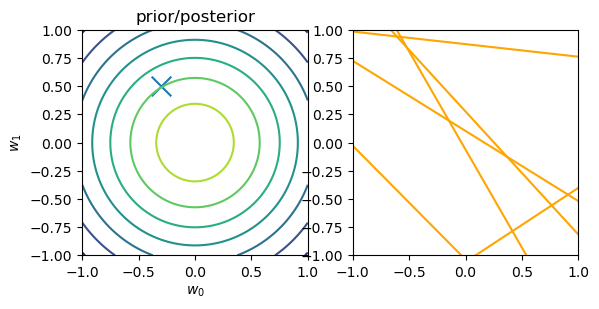

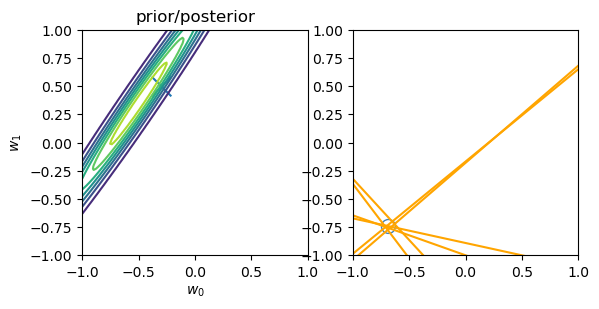

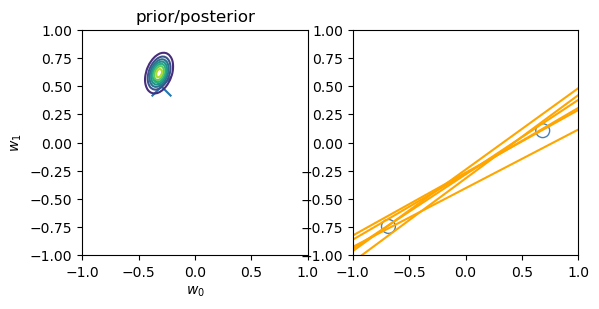

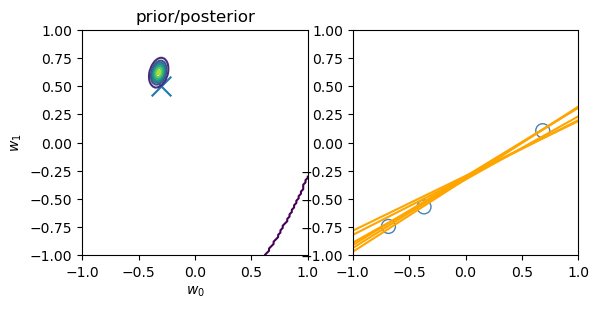

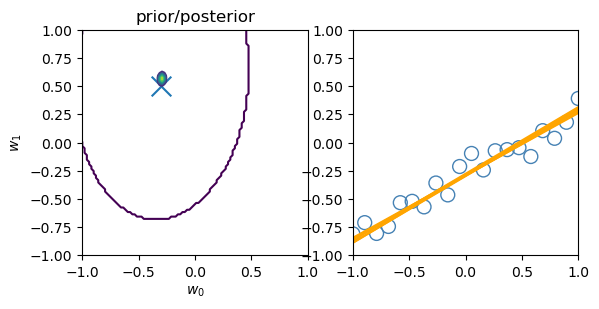

In [8]:
# this example is introduced from Chapter 3, PRML
from scipy.stats import multivariate_normal
def linear(x):
    return -0.3 + 0.5 * x
def create_toy_data(func, sample_size, std, domain=[0, 1]):
    x = np.linspace(domain[0], domain[1], sample_size)
    np.random.shuffle(x)
    t = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, t


x_train, y_train = create_toy_data(linear, 20, 0.1, [-1, 1])
x = np.linspace(-1, 1, 100)
w0, w1 = np.meshgrid(
    np.linspace(-1, 1, 100),
    np.linspace(-1, 1, 100))
w = np.array([w0, w1]).transpose(1, 2, 0)
feature = PolynomialFeature(degree=1)
X_train = feature.transform(x_train)
X = feature.transform(x)
model = BayesianRegression(alpha=1, beta=100.)

for begin, end in [[0, 0], [0, 1], [0, 2], [0, 3], [0, 20]]:
    model.fit(X_train[begin: end], y_train[begin: end])
    plt.subplot(1, 2, 1)
    plt.scatter(-0.3, 0.5, s=200, marker="x")
    plt.contour(w0, w1, multivariate_normal.pdf(w, mean
                                                =model.w_mean, cov=model.w_cov))
    plt.gca().set_aspect('equal')
    plt.xlabel("$w_0$")
    plt.ylabel("$w_1$")
    plt.title("prior/posterior")

    plt.subplot(1, 2, 2)
    plt.scatter(x_train[begin:end], y_train[begin:end], s=100, facecolor="none", edgecolor="steelblue", lw=1)
    plt.plot(x, model.predict(X, sample_size=6), c="orange")
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

# Question 1: 
- Investigate how the sampled (orange) lines evolve as more data becomes available. What do you observe?
- What is the effect of changing $\alpha$ and $\beta$? Experiment with different settings of $\alpha$ and $\beta$.
- What value of $\beta$ matches the ground truth model?
- What is the benefit of this Bayesian model compared to standard linear regression?

# Comparison of the three approaches on real data
## Import data

In [9]:
# This tutorial example refers to Chapter 2 of Hands-on ML
from sklearn.datasets import load_boston
import pandas as pd

boston_data = load_boston()
boston_df = pd.DataFrame(boston_data.data, columns=boston_data.feature_names)
boston_df['MEDV'] = boston_data.target

In [10]:
boston_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [11]:
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## Exploratory analysis

The correlation matrix:


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.00,-0.20,0.41,-0.06,0.42,-0.22,0.35,-0.38,0.63,0.58,0.29,-0.39,0.46,-0.39
ZN,-0.20,1.00,-0.53,-0.04,-0.52,0.31,-0.57,0.66,-0.31,-0.31,-0.39,0.18,-0.41,0.36
INDUS,0.41,-0.53,1.00,0.06,0.76,-0.39,0.64,-0.71,0.60,0.72,0.38,-0.36,0.60,-0.48
CHAS,-0.06,-0.04,0.06,1.00,0.09,0.09,0.09,-0.10,-0.01,-0.04,-0.12,0.05,-0.05,0.18
NOX,0.42,-0.52,0.76,0.09,1.00,-0.30,0.73,-0.77,0.61,0.67,0.19,-0.38,0.59,-0.43
RM,-0.22,0.31,-0.39,0.09,-0.30,1.00,-0.24,0.21,-0.21,-0.29,-0.36,0.13,-0.61,0.70
AGE,0.35,-0.57,0.64,0.09,0.73,-0.24,1.00,-0.75,0.46,0.51,0.26,-0.27,0.60,-0.38
DIS,-0.38,0.66,-0.71,-0.10,-0.77,0.21,-0.75,1.00,-0.49,-0.53,-0.23,0.29,-0.50,0.25
RAD,0.63,-0.31,0.60,-0.01,0.61,-0.21,0.46,-0.49,1.00,0.91,0.46,-0.44,0.49,-0.38
TAX,0.58,-0.31,0.72,-0.04,0.67,-0.29,0.51,-0.53,0.91,1.00,0.46,-0.44,0.54,-0.47


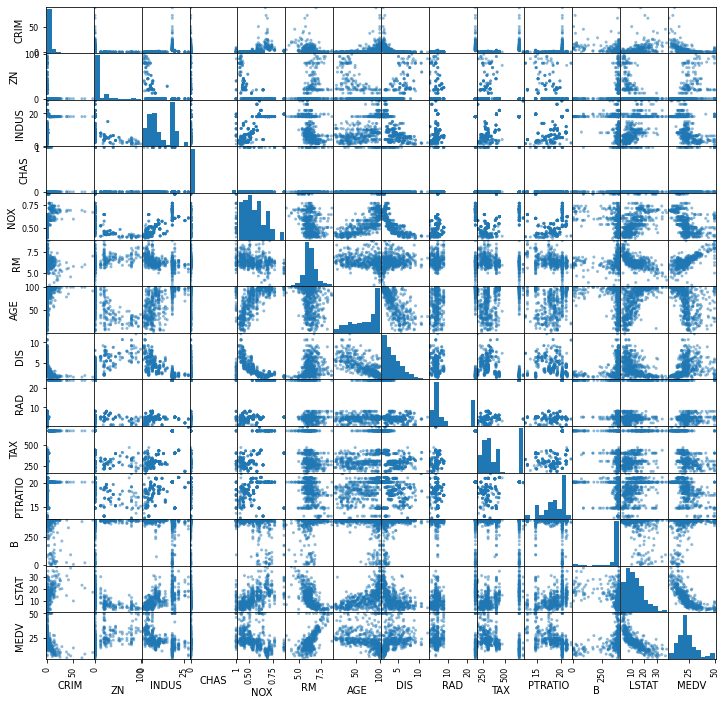

In [12]:
#Scatter plot of the data
from pandas.plotting import scatter_matrix

scatter_matrix(boston_df,figsize = (12,12))
print('The correlation matrix:')
corr_mtx = boston_df.corr()
corr_mtx.round(2)

We display the most correlated attribute against the target values:

In [13]:
corr_mtx['MEDV'].abs().sort_values(ascending = False)

MEDV       1.000000
LSTAT      0.737663
RM         0.695360
PTRATIO    0.507787
INDUS      0.483725
TAX        0.468536
NOX        0.427321
CRIM       0.388305
RAD        0.381626
AGE        0.376955
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
Name: MEDV, dtype: float64

## Train-Test Split and Standarization

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## convert the dataframe to numpy array
boston_array = boston_df.to_numpy()
X,y = boston_array[:,:13],boston_array[:,-1]

## We can also directly import X,y from sklearn (without using pandas package)
# X,y = load_boston(return_X_y=True)


## Spliting training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(X.shape,y.shape,X_train.shape, y_train.shape, X_test.shape, y_test.shape )

(506, 13) (506,) (404, 13) (404,) (102, 13) (102,)


In [15]:
from sklearn.preprocessing import StandardScaler
# standarization
std_trans = StandardScaler()
X_train = std_trans.fit_transform(X_train)
X_test = std_trans.transform(X_test)

## Recursive Learning: adjusting the Bayesian model after each data point
It helps to explore different combinations of $\alpha$ and $\beta$ in the following Bayesian experiment. In this way, you can get a sense of the influence of the prior.

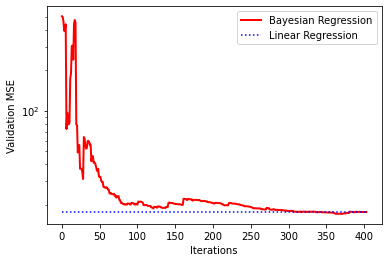

In [16]:
feature = PolynomialFeature(degree=1)
X_train1, X_test1 = feature.transform(X_train), feature.transform(X_test)
Linear = LinearRegression()
Linear.fit(X_train1, y_train)
errors_linear = mean_squared_error(Linear.predict(X_test1),y_test)

Bayes = BayesianRegression(alpha=1., beta=100.)
errors_bayes = []

for idx in range(X_train1.shape[0]):
    Bayes.fit(X_train1[idx:idx+1], y_train[idx:idx+1])
    errors_bayes.append(mean_squared_error(Bayes.predict(X_test1),y_test))

    
plt.plot(errors_bayes,  'r', label = 'Bayesian Regression' ,linewidth = 2.)
plt.plot([errors_linear]*X_train1.shape[0], 'b:', label = 'Linear Regression')

plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Validation MSE')
plt.legend()



# Question 2: 
- What MSE does this model achieve for the given values of $\alpha$ and $\beta$?
- What is the effect of changing $\alpha$ and $\beta$ on the MSE? Experiment with different settings of $\alpha$ and $\beta$.
- What value of $\beta$ yields the lowest MSE? Does it match standard deviation in the ground truth model?

## Empirical Bayes Approach

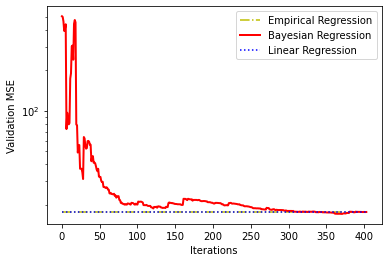

In [17]:
empirical_Bayes = EmpiricalBayesRegression(alpha=1., beta=100.)
empirical_Bayes.fit(X_train1, y_train)
errors_empirical = mean_squared_error(empirical_Bayes.predict(X_test1),y_test)
plt.plot([errors_empirical]*X_train1.shape[0], 'y-.', label = 'Empirical Regression')
plt.plot(errors_bayes,  'r', label = 'Bayesian Regression' ,linewidth = 2.)
plt.plot([errors_linear]*X_train1.shape[0], 'b:', label = 'Linear Regression')

plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Validation MSE')
plt.legend()

# Question 3: 
- Plot the parameters $\alpha$ and $\beta$ for each iteration of the empirical Bayes algorithm. 
- What are the values of $\alpha$ and $\beta$ at convergence? Try to interpret those value; does the prior have much weightage?  Compare also those values to the values you experimented with in Question 2.

## Expectation Maximization Algorithm

<function matplotlib.pyplot.show(*args, **kw)>

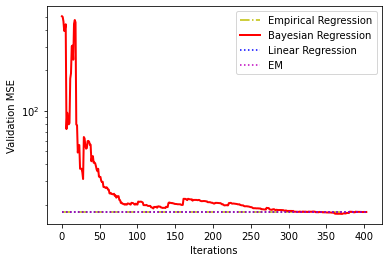

In [18]:
np.random.seed(51)
EM = EM(alpha=1., beta=1.)
EM.fit(X_train1, y_train)
errors_EM = mean_squared_error(EM.predict(X_test1),y_test)
plt.plot([errors_empirical]*X_train1.shape[0], 'y-.', label = 'Empirical Regression')
plt.plot(errors_bayes,  'r', label = 'Bayesian Regression' ,linewidth = 2.)
plt.plot([errors_linear]*X_train1.shape[0], 'b:', label = 'Linear Regression')
plt.plot([errors_EM]*X_train1.shape[0], 'm:', label = 'EM')

plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Validation MSE')
plt.legend()
plt.show



# Question 4: 
- Plot the parameters $\alpha$ and $\beta$ for each iteration of the EM algorithm. 
- What are the values of $\alpha$ and $\beta$ at convergence? Try to interpret those value; does the prior have much weightage?  Compare also those values to the values you obtained in Question 3 for the empirical Bayes approach.

## Variational Bayes Algorithm

<function matplotlib.pyplot.show(*args, **kw)>

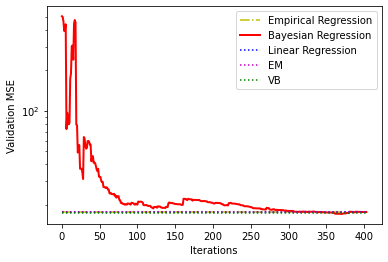

In [19]:
np.random.seed(51)
VB = VB(alpha=1., beta=1.)
VB.fit(X_train1, y_train)
errors_VB = mean_squared_error(VB.predict(X_test1),y_test)


plt.plot([errors_empirical]*X_train1.shape[0], 'y-.', label = 'Empirical Regression')
plt.plot(errors_bayes,  'r', label = 'Bayesian Regression' ,linewidth = 2.)
plt.plot([errors_linear]*X_train1.shape[0], 'b:', label = 'Linear Regression')
plt.plot([errors_EM]*X_train1.shape[0], 'm:', label = 'EM')
plt.plot([errors_VB]*X_train1.shape[0], 'g:', label = 'VB')

plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Validation MSE')
plt.legend()
plt.show



# Question 5: 
- Plot the parameters $\alpha$ and $\beta$ for each iteration of the VB algorithm. Since $\alpha$ is now a vector, you can perhaps plot the median or mean of $\alpha$, instead of the individual components.
- What are the values of $\alpha$ and $\beta$ at convergence? Create a bar plot of the $\alpha$ values at convergence. Try to interpret those value; does the prior have much weightage? Are some $\alpha$ values large, and if so, what does that mean? Compare also those values to the values you obtained in Question 3 and 4 for the empirical Bayes and EM approach respectively.

## Model Selection
We can conduct model selection with the empirical Bayesian approach. Given a number of features $n$, we select the most $n$ significant features (according to the correlation matrix). We then fit the empirical Bayesian model and compute its evidence. We can then select the best model according to the evidence.

(404, 14)


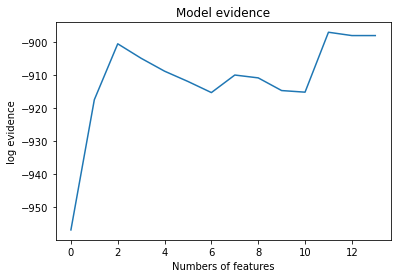

[-956.9743286499274, -917.4209897809733, -900.437027915362, -904.83963990783, -908.7528104392071, -911.8817768763587, -915.2528067663529, -909.9235551817674, -910.7887867647702, -914.6399110155501, -915.1287052598819, -896.9246050283683, -897.9349127747923, -897.9349127747923]


In [20]:
index_sort = (sorted(list(range(13)), key = lambda i: corr_mtx['MEDV'].abs()[i], reverse = True))
evidences = []

models = []
indexes = np.arange(1,14)
print(X_train1.shape)

for num_feature in range(14):
    slice_index = index_sort[:num_feature+1]
    tmp_X = feature.transform(X_train[:,slice_index])
    model = EmpiricalBayesRegression()
    model.fit(tmp_X, y_train)
    evidences.append(model.log_evidence(tmp_X, y_train))
    models.append(model)


plt.plot(evidences)
plt.title("Model evidence")
plt.xlabel("Numbers of features")
plt.ylabel("log evidence")
plt.show()
print(evidences)

[12, 5, 10, 2, 9, 4, 0, 8, 6, 1, 11, 7, 3]
(404, 12) (102, 12)
19.41289659965896 19.413930559786934 19.35580929962866


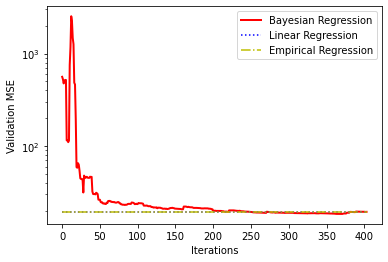

In [21]:
slice_index = index_sort[:11]
print(index_sort)
X_train_modified, X_test_modified = feature.transform(X_train[:,slice_index]), feature.transform(X_test[:,slice_index])
print(X_train_modified.shape, X_test_modified.shape)

Linear = LinearRegression()
Linear.fit(X_train_modified, y_train)
errors_linear = mean_squared_error(Linear.predict(X_test_modified),y_test)

Bayes = BayesianRegression(alpha=1., beta=100.)
errors_bayes = []

empirical_Bayes = EmpiricalBayesRegression()
empirical_Bayes.fit(X_train_modified, y_train)
errors_embayes = mean_squared_error(empirical_Bayes.predict(X_test_modified),y_test)

for idx in range(X_train.shape[0]):
    Bayes.fit(X_train_modified[idx:idx+1], y_train[idx:idx+1])
    errors_bayes.append(mean_squared_error(Bayes.predict(X_test_modified),y_test))
    
    
plt.plot(errors_bayes,  'r', label = 'Bayesian Regression' ,linewidth = 2.)
plt.plot([errors_linear]*X_train.shape[0], 'b:', label = 'Linear Regression')
plt.plot([errors_embayes]*X_train.shape[0], 'y-.', label = 'Empirical Regression')

plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Validation MSE')
plt.legend()
print(errors_bayes[-1],errors_linear,errors_embayes)




# Question 6: 
- Does model selection in the empirical Bayes method help to reduce the prediction error? 
- Try to interpret the feature set corresponding to the lowest prediction error. 

## Other implementations [optional]
There are implementations for the LS and empirical Bayes methods in the scikit-learn Python library. The implementation in scikit-learn of the empirical Bayes method adopts different optimization methods and might be more robust than the implementations provided above.

Note that there is another difference between the implementations above and the Scikit-implementations. The Scikit class does not require the constant column in the input, while the implementations above requires the constant column added, before it is fed into the fit method.

In [22]:
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression
Linear_sk = LinearRegression()
Linear_sk.fit(X_train_modified[:,1:], y_train)
errors_linear_sk = mean_squared_error(Linear_sk.predict(X_test_modified[:,1:]),y_test)
empirical_Bayes_sk = BayesianRidge()
empirical_Bayes_sk.fit(X_train_modified[:,1:], y_train)
errors_empirical_sk = mean_squared_error(empirical_Bayes_sk.predict(X_test_modified[:,1:]),y_test)
print('Linear Regression MSE:',errors_linear,' sklearn Linear Regression MSE:', errors_linear_sk)
print('empirical Bayes MSE:',errors_embayes,' sklearn empirical Bayes MSE:', errors_empirical_sk)

Linear Regression MSE: 19.413930559786934  sklearn Linear Regression MSE: 19.41393055978695
empirical Bayes MSE: 19.35580929962866  sklearn empirical Bayes MSE: 19.258607580699213
